<a href="https://colab.research.google.com/github/educanto/blood_cell_classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0eecef4ff124232386d0ea5449b27442ec3ec910ebc9f367383e61c4c8c66c36
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80

In [ ]:
from google.colab import files
from google.colab.patches import cv2_imshow

import os
import json
import cv2
from collections import defaultdict
import numpy as np
import xml.etree.ElementTree as ET

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from mediapipe_model_maker import object_detector

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Mount drive**

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/IA/Medical/Blood Cell Classification'   # Script location
os.chdir(root_path)

Mounted at /content/drive


# **Utilities**

In [ ]:
MARGIN = 5  # pixels
ROW_SIZE = 15  # pixels
FONT_SIZE = 0.5
FONT_THICKNESS = 1
TEXT_COLOR = (0, 255, 0)
BOX_COLOR = (255, 0, 0)
BOX_THICKNESS = 1

def visualize(image, detection_result=None, xml=None) -> np.ndarray:
    if detection_result is not None:
        for detection in detection_result.detections:
            # Draw bounding_box
            bbox = detection.bounding_box
            start_point = bbox.origin_x, bbox.origin_y
            end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
            cv2.rectangle(image, start_point, end_point, BOX_COLOR, BOX_THICKNESS)

            # Draw label and score
            category = detection.categories[0]
            category_name = category.category_name
            probability = round(category.score, 2)
            result_text = category_name
            prob_text = str(probability)
            result_location = (MARGIN + bbox.origin_x,
                            MARGIN + ROW_SIZE + bbox.origin_y)
            prob_location = (MARGIN + bbox.origin_x,
                            MARGIN + 3*ROW_SIZE + bbox.origin_y)
            cv2.putText(image, result_text, result_location, cv2.FONT_HERSHEY_SIMPLEX,
                        FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)
            cv2.putText(image, prob_text, prob_location, cv2.FONT_HERSHEY_SIMPLEX,
                        FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

    if xml is not None:
        # Optional: Draw true bounding_boxes
        tree = ET.parse(xml)
        root = tree.getroot()

        for obj in root.findall('.//object'):
            true_cat = obj.find('name').text
            true_bbox = obj.find('bndbox')
            xmin = int(true_bbox.find('xmin').text)
            ymin = int(true_bbox.find('ymin').text)
            xmax = int(true_bbox.find('xmax').text)
            ymax = int(true_bbox.find('ymax').text)

            start_point = (xmin, ymin)
            end_point = (xmax, ymax)
            cv2.rectangle(image, start_point, end_point, (0, 0, 255), BOX_THICKNESS)

            result_location = (MARGIN + xmin, MARGIN + ROW_SIZE + ymin)
            cv2.putText(image, true_cat, result_location, cv2.FONT_HERSHEY_SIMPLEX,
                        FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

    if detection_result is None and xml is None:
        return None

    return image


def draw_box(image, bb):
    cv2.rectangle(image, (bb[0], bb[1]), (bb[2], bb[3]), BOX_COLOR, BOX_THICKNESS)

def draw_text(image, bb, txt, disp):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, txt, (int(bb[0] + disp), int(bb[1] + 2*disp)), font, FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

def draw_bbox(image, annotation_list, image_shape):
    for annotation in annotation_list:
        xmin = int(annotation.find('bndbox/xmin').text)
        ymin = int(annotation.find('bndbox/ymin').text)
        xmax = int(annotation.find('bndbox/xmax').text)
        ymax = int(annotation.find('bndbox/ymax').text)

        class_name = annotation.find('name').text

        draw_box(image, (xmin, ymin, xmax, ymax))
        draw_text(image, (xmin, ymin, xmax, ymax), class_name, image_shape[0] * 0.01)

def visualize_dataset(data_dir, max_examples=None):
    images_dir = os.path.join(data_dir, 'images')

    annotations_dir = os.path.join(data_dir, 'Annotations')

    if max_examples is None:
        max_examples = len(os.listdir(annotations_dir))

    for ind, xml_file in enumerate(os.listdir(annotations_dir)[:max_examples]):
        xml_path = os.path.join(annotations_dir, xml_file)

        tree = ET.parse(xml_path)
        root = tree.getroot()

        image_file = root.find("filename").text
        print(f"Visualizing {ind+1}/{max_examples}:{image_file}")

        img_path = os.path.join(images_dir, image_file)

        img = mp.Image.create_from_file(img_path).numpy_view()

        draw_bbox(img, root.findall('object'), img.shape)

        rgb_annotated_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2_imshow(rgb_annotated_image)

# **Load data**

**Load data**

In [ ]:
dataset_path = "formated_dataset"

In [ ]:
train_data = object_detector.Dataset.from_pascal_voc_folder(data_dir=os.path.join(dataset_path,'train'))
print("train_data size: ", train_data.size)

train_data size:  384


In [ ]:
valid_data = object_detector.Dataset.from_pascal_voc_folder(data_dir=os.path.join(dataset_path,'valid'))
print("valid_data size: ", valid_data.size)

valid_data size:  73


In [ ]:
test_data = object_detector.Dataset.from_pascal_voc_folder(data_dir=os.path.join(dataset_path,'test'))
print("test_data size: ", test_data.size)

test_data size:  35


**See some data**

In [ ]:
visualize_dataset(os.path.join(dataset_path,'train'), 20)

# **Train model**

**Build model**

In [ ]:
spec = object_detector.SupportedModels.MOBILENET_V2_I320
hparams = object_detector.HParams(learning_rate=0.1,
                                  batch_size=32,
                                  epochs=40,
                                  shuffle=True,
                                  export_dir='exported_model')

options = object_detector.ObjectDetectorOptions(
    supported_model=spec,
    hparams=hparams
)

**Train**

In [ ]:
model = object_detector.ObjectDetector.create(
    train_data=train_data,
    validation_data=valid_data,
    options=options)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Model: "retina_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_net (MobileNet)      {'2': (None, 80, 80, 24   2257984   
                             ),                                  
                              '3': (None, 40, 40, 32             
                             ),                                  
                              '4': (None, 20, 20, 96             
                             ),                                  
                              '5': (None, 10, 10, 32             
                             0),                                 
                              '6': (None, 10, 10, 12             
                             80)}                                
                                                                 
 fpn (FPN)                   {'5': (None, 10, 10, 12   130880    
                             8),                  

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


12/12 [==============================] - 381s 28s/step - total_loss: 2.4621 - cls_loss: 1.9960 - box_loss: 0.0082 - model_loss: 2.4053 - val_total_loss: 1.5003 - val_cls_loss: 1.1488 - val_box_loss: 0.0059 - val_model_loss: 1.4435
Epoch 2/40
12/12 [==============================] - 318s 26s/step - total_loss: 1.6123 - cls_loss: 1.1698 - box_loss: 0.0077 - model_loss: 1.5555 - val_total_loss: 1.4076 - val_cls_loss: 1.0708 - val_box_loss: 0.0056 - val_model_loss: 1.3508
Epoch 3/40
12/12 [==============================] - 305s 25s/step - total_loss: 1.4465 - cls_loss: 1.0406 - box_loss: 0.0070 - model_loss: 1.3897 - val_total_loss: 1.2188 - val_cls_loss: 0.9015 - val_box_loss: 0.0052 - val_model_loss: 1.1620
Epoch 4/40
12/12 [==============================] - 261s 22s/step - total_loss: 1.2315 - cls_loss: 0.8642 - box_loss: 0.0062 - model_loss: 1.1747 - val_total_loss: 1.0445 - val_cls_loss: 0.7468 - val_box_loss: 0.0048 - val_model_loss: 0.9877
Epoch 5/40
12/12 [=========================

**Evaluate model**

In [ ]:
loss, coco_metrics = model.evaluate(test_data, batch_size=32)
print(f"Validation loss: {loss}")
print(f"Validation coco metrics: {coco_metrics}")

2/2 [==============================] - 5s 619ms/step - total_loss: 0.5074 - cls_loss: 0.3369 - box_loss: 0.0023 - model_loss: 0.4507
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.55s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.521
 Average Recall     (AR) @[ Io

**Export model**

In [ ]:
model.export_model()

Exporting a floating point model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


# **Load model**

In [ ]:
base_options = python.BaseOptions(model_asset_path='exported_model/model.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

**Prediction**

Predictions


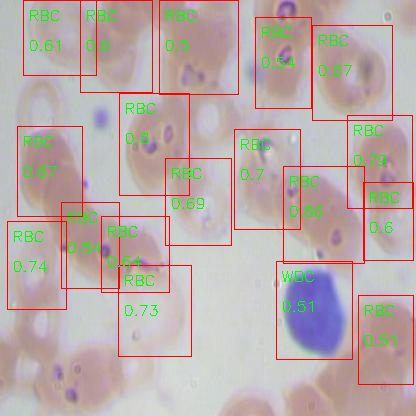

True


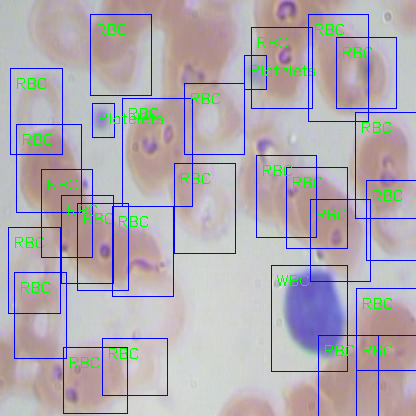

In [ ]:
image_path = 'formated_dataset/test/images/BloodImage_00038_jpg.rf.2ba38cd0bc8d5867c68f14cc07c7dd3b.jpg'

xml_path = image_path.replace("images", "Annotations").replace(".jpg", ".xml")

image = mp.Image.create_from_file(image_path)

detection_result = detector.detect(image)

print('Predictions')
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result=detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

print('True')
image_copy = np.copy(image.numpy_view())
orig_image = visualize(image_copy, xml=xml_path)
rgb_orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_orig_image)